In [1]:
%%capture

from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Colab Notebooks/RP/
  %pip install mangoes

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import mangoes
from tqdm import tqdm

In [16]:
from tools.readers import SemEvalReader
from tools.utils import standardize, OrthogProcrustAlign
from tools.count_based import compute_SVD_representation, creates_count_matrices_pair, create_ppmi_matrices_pair, load_ppmi_matrices_as_csr

In [4]:
language = 'english'
path_data = '../semeval2020_ulscd_posteval/starting_kit/test_data_public'

with open(f'{path_data}/{language}/targets.txt','r') as f:
  targets = f.read().split('\n')
targets.pop(-1)
targets_words = [ w.split('_')[0] for w in targets]
targets_words;

In [7]:
reader = SemEvalReader('../semeval2020_ulscd_posteval/starting_kit/test_data_public')

In [9]:
language = 'english'
targets, gold_scores = reader.read_targets(language)
corpus1, corpus2 = reader.load_corpora(language,'lemma')

[INFO] Building corpus 1...


Counting words: 0it [00:00, ?it/s]

[INFO] Corpus 1: 253644 sentences 	86557 words
[INFO] Building corpus 2...


Counting words: 0it [00:00, ?it/s]

[INFO] Corpus 2: 353692 sentences 	149891 words


In [12]:
counts_matrix1, counts_matrix2, vocabulary = creates_count_matrices_pair(corpus1,corpus2,window_size=10)

[INFO] Creating shared vocabulary...
86557 words in corpus 1
149891 words in corpus 2
Shared vocabulary size: 33954
[INFO] Computing count matrix for corpus 1...
[INFO] Success!
[INFO] Computing count matrix for corpus 2...
[INFO] Success!


In [13]:
word2index = dict()
idx2word = dict()
for i, word in enumerate(list(vocabulary.words)):
    word2index[word]=i
    idx2word[i] = word

In [18]:
alpha = 0.75
shift = 1
folder= './matrices/{}/'.format(language)

create_ppmi_matrices_pair(counts_matrix1, counts_matrix2, alpha, shift, storage_folder=folder, verbose=True)

[INFO] Computing PPMI matrices with alpha=0.75 and k=1.
[INFO] Computing PPMI matrix for Corpus 1...
[INFO] Success!
[INFO] Computing PPMI matrix for Corpus 2...
[INFO] Success!
[INFO] Matrices stored in ./matrices/english//.


In [21]:
ppmi1, ppmi2 = load_ppmi_matrices_as_csr(folder)

In [22]:
counts_matrix1.contexts_words.words == vocabulary.words

True

In [62]:
distances_ppmi = np.empty( len(targets) )
for i, word in tqdm(enumerate(targets)):
    index = word2index[word]
    distances_ppmi[i] = sc.spatial.distance.cosine(ppmi1[index].toarray(),ppmi2[index].toarray())

37it [00:00, 969.21it/s]


In [63]:
index = word2index['head']
sc.spatial.distance.cosine(ppmi1[index].toarray(),ppmi2[index].toarray())

0.9357590813708107

In [64]:
sc.stats.spearmanr( distances_ppmi, gold_scores )

SpearmanrResult(correlation=0.2679471261768914, pvalue=0.10884802317876088)

In [29]:
#gamma has no importance as we standardize vectors for OP alignement.
svd1 = standardize(compute_SVD_representation(ppmi1,300,0))
svd2 = standardize(compute_SVD_representation(ppmi2,300,0))
svd2.shape

(33954, 300)

In [30]:
W_align_SVD = OrthogProcrustAlign(svd1,svd2,True)

In [31]:
svd2_aligned = svd2.dot(W_align_SVD)

In [32]:
word = 'then'
index = word2index[word]

#print("PPMI dist : ",1-sc.spatial.distance.cosine(ppmi1[index].toarray(),ppmi2[index].toarray()) )
print("SVD sim : ",1-sc.spatial.distance.cosine(svd1[index],svd2_aligned[index]) )


SVD sim :  0.6739310673656783


In [33]:
distances = np.empty( len(targets) )
for i, word in tqdm(enumerate(targets)):
    index = word2index[word]
    distances[i] = sc.spatial.distance.cosine(svd1[index],svd2_aligned[index])

37it [00:00, 10901.18it/s]


In [34]:
sc.stats.spearmanr( distances, gold_scores )

SpearmanrResult(correlation=0.26035924295772284, pvalue=0.11963077130539562)

In [242]:
for i, word in enumerate(targets):
    print(word, '   ', distances[i])

attack_nn     0.5368043348882782
bag_nn     0.6257434874464112
ball_nn     0.7893354013071767
bit_nn     0.7016696635584507
chairman_nn     0.6677755646939906
circle_vb     0.5933127865486416
contemplation_nn     0.7395080165207808
donkey_nn     0.4686237277284401
edge_nn     0.6381748361069481
face_nn     0.2902404349542549
fiction_nn     0.7437715812841689
gas_nn     0.45176926851316357
graft_nn     0.7536098025288992
head_nn     0.5151391053081857
land_nn     0.6304555859194855
lane_nn     0.6820153049209985
lass_nn     0.7292272614208823
multitude_nn     0.9480615466743719
ounce_nn     0.6308174148588156
part_nn     0.6285949484432298
pin_vb     0.738097442255857
plane_nn     0.8142449407336517
player_nn     0.8211617307308727
prop_nn     0.8102912877334203
quilt_nn     0.6181872781310356
rag_nn     0.6089819982798836
record_nn     0.8272739737170476
relationship_nn     0.8645501463185454
risk_nn     0.8198892287395655
savage_nn     0.7365717535239797
stab_nn     0.6449060947466236

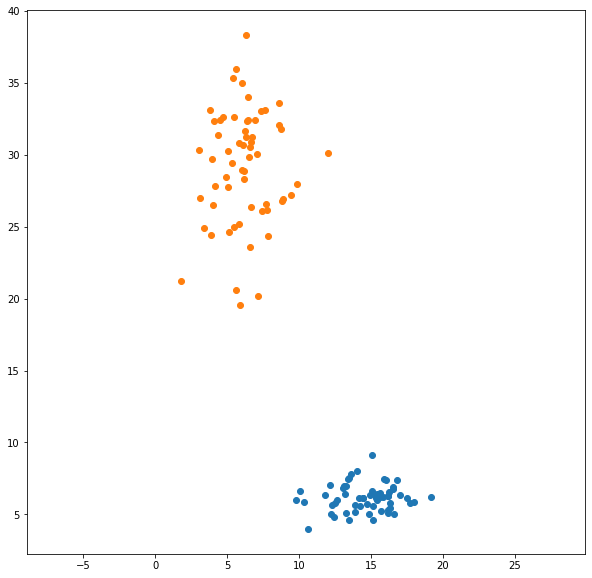

In [177]:
import matplotlib.pyplot as plt 


A = np.random.normal(loc=(15,6),scale=(2,1),size=(60,2))

factor=2
B = factor*(np.array((A[:,1],A[:,0])) ).T
B[:,0] = A[:,1].mean()+ (B[:,0] - B[:,0].mean())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.set_xlim((-3,10))
# ax.set_ylim((-3,10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.scatter(A.T[0],A.T[1])
ax.scatter(B.T[0],B.T[1])

plt.axis('equal')

plt.show()

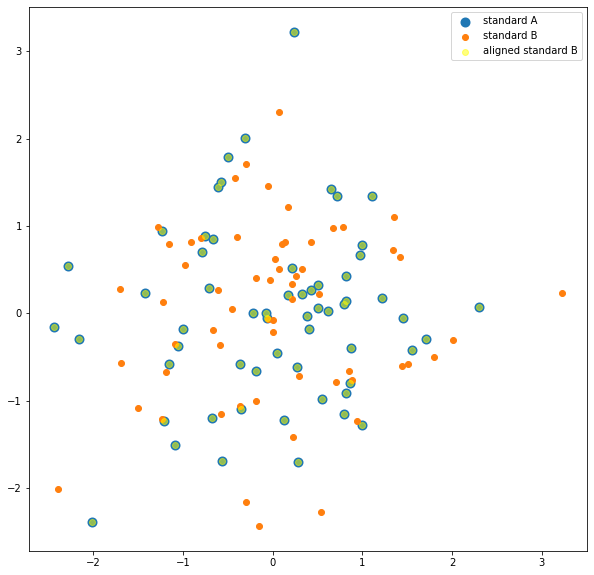

In [237]:
A_std = standardize(A)
B_std = standardize(B)

ab_align = OrthogProcrustAlign(A_std,B_std)
C = B_std.dot(ab_align)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.set_xlim((-3,10))
# ax.set_ylim((-3,10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.scatter(A_std.T[0],A_std.T[1],lw=4,label='standard A')
ax.scatter(B_std.T[0],B_std.T[1],label='standard B')
ax.scatter(C.T[0],C.T[1],lw=1,alpha=0.5,c='yellow', label='aligned standard B')

plt.legend()
plt.show()

In [103]:
counts_matrix1['the'].toarray()

array([[ 0,  2,  3, ...,  6,  0, 10]], dtype=int32)

In [117]:
M1 = mangoes.create_representation(counts_matrix1, weighting=mangoes.weighting.ShiftedPPMI(alpha=alpha,shift=shift))

In [124]:
M1.save('./test/')